Isolation Forest is one of the most used techniques to detect anomalies in the data. It’s based on a “forest” of trees, where each isolation tree isolates anomalous observations from the rest of the data points. Despite its simplicity, speed and intuitiveness, there is a drawback. The lack of explanation. Why is a particular observation considered anomalous by the algorithm? How can the output be interpreted?
There are two possible interpretations, Global and Local. Global because the goal is to explain the model as a whole and understand what features have a more relevant role in the general model. On the other hand, we need to look at the model locally to have an idea of the features that influence a specific prediction of the model. The features can vary passing from a local to a global explanation and vice versa.

I will show how to comprehend the decisions taken by Isolation Forest in detecting anomalies in the data. This is possible using the data visualizations provided by SHAP. For the global interpretation, you’ll see the summary plot and the global bar plot, while for local interpretation two most used graphs are the force plot, the waterfall plot and the scatter/dependence plot.

## 2. Train Isolation Forest


In [4]:
import numpy as np 
import pandas as pd
import shap
from sklearn.datasets import load_boston
from sklearn.ensemble import IsolationForest

boston = load_boston()
df = pd.DataFrame(data=boston.data,columns=boston.feature_names)
df['target']=boston.target
df.head()
X = df.drop('target', axis=1)
y = df['target']

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

It contains 506 neighbourhood regions around Boston. The typical task is to predict the median value of owner-occupied homes, but in this case, we want to train the isolation forest to divide the dataset into normal and anomalous observations. There are 13 features and the target variable in this dataset:

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The dataset is not originally designed for an anomaly detection task, but let’s suppose that there are anomalous data entries. For example, in the list, we could have houses with very low prices in the centre of Boston, a little too cheap with respect to the buildings in the same area. Then, the goal is to distinguish these anomalous cases from the normal ones.
For this anomaly detection problem, we’ll use the Isolation forest. There are some advantages to use this model. First, it’s unsupervised and we don’t need target labels (that we don’t have) to train the model. Second, there are two useful properties considered to detect anomalies:
The anomalies are few in numbers, so it constitutes a minority class
The anomalous observations are characterized to have very different values of features from the instances.

The idea is that the isolation procedure should isolate fastly the outliers at small depths, while the normal instances are usually at the bottom of the tree. For all these properties, the Isolation tree was taken into consideration in the Boston housing dataset.
Let’s create the model using the IsolationForest function from sklearn library. We’ll fix the random state equal to 42 to reproduce the same output every time. The proportion of anomalies in our dataset is specified by the argument “contamination” and will be automatically determined. The typical value is 0.1 and usually depends on the dimension of the dataset.

In [6]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination='auto', max_features=13, 
                          bootstrap=False, n_jobs=-1, random_state=42)

iforest.fit(X)

y_pred = iforest.predict(X)

df['anomaly_label']=y_pred
print(df.anomaly_label.unique())
df[df.anomaly_label==-1].head()

[ 1 -1]


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,anomaly_label
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5,-1
54,0.01360,75.0,4.00,0.0,0.410,5.888,47.6,7.3197,3.0,469.0,21.1,396.90,14.80,18.9,-1
57,0.01432,100.0,1.32,0.0,0.411,6.816,40.5,8.3248,5.0,256.0,15.1,392.90,3.95,31.6,-1
141,1.62864,0.0,21.89,0.0,0.624,5.019,100.0,1.4394,4.0,437.0,21.2,396.90,34.41,14.4,-1
142,3.32105,0.0,19.58,1.0,0.871,5.403,100.0,1.3216,5.0,403.0,14.7,396.90,26.82,13.4,-1


In [7]:
df['target']=df['anomaly_label'].apply(lambda x: 1 if x==-1 else 0)

To train the model, we’ll use all the dataset because we don’t have prior knowledge of the anomalous observations. So, it’s an unsupervised problem. Once the model is trained, we can make the predictions and save them in a column, called anomaly_label. It assigns -1 to the anomalous observations and 1 to the inliers.

## 3. Compute SHAP values


SHAP provides implementations of explanations that leverage Shapley values. TreeExplainer for models based on trees, DeepExplainer and GradientExplainer for neural networks. Last, KernelExplainer and Explainer are applied for any type of model.
Even if it’s a model based on trees, the TreeExplainer doesn’t work well with Isolation Forest. So, I will apply the Explainer function.
Now, I will show the magical rows of code that will make you discover the secrets of the model’s output.

In [8]:
explainer = shap.Explainer(iforest.predict, X)
shap_values = explainer(X)

Permutation explainer: 507it [11:46,  1.41s/it]                         


First, we defined the explainer object, using the function Explainer that performs the isolation forest by taking the prediction method. Once this object is created, you can obtain the Shapley values. Before beginning to display the SHAP’s plot, you need to load the Javascript library:

In [30]:
import matplotlib.pyplot as plt
import matplotlib

In [31]:
shap.initjs()

matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.


## 4. Explain Single Prediction
We can start by explaining single predictions of our model. A clear way to observe the contribution of each feature in the model’s outcome is to display the **force plot**. I will show the outcome of the 142nd item, which was previously classified as an anomaly by the algorithm.

In [24]:
from shap.plots import *

matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.


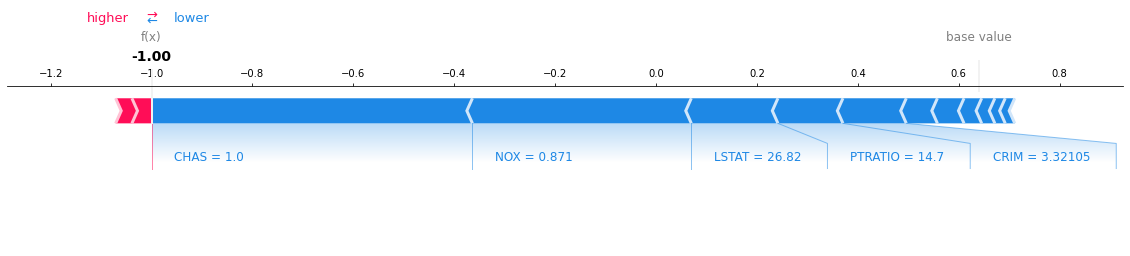

In [43]:
shap.initjs()
shap.plots.force(shap_values[142], matplotlib=True)

There are three important aspects in this plot:
* **The predicted value f(x)** is -1, meaning that we have an anomaly. In the case it’s normal, the output value should be equal to 1.

* The **base value**, which is the average value of the target variable across all the rows of the dataset, is 0.64. You can see how the feature values increase or decrease the prediction. The double arrow indicates the impact of each feature with respect to the baseline of 0.64.

* The features coloured in red show how they contribute to increasing the value of the prediction. The blue colour indicates how the features contribute to decreasing the prediction. In this case, the features coloured in blue are determinants to find the anomalous item, while the contribution of the variable ZN is not enough to classify that observation as normal. The length of each arrow represents the impact of that feature on the prediction.

The feature values of the 142nd row are showed in the plot, as you can see if you select the observation in the data frame:

In [37]:
df.loc[142]

CRIM               3.32105
ZN                 0.00000
INDUS             19.58000
CHAS               1.00000
NOX                0.87100
RM                 5.40300
AGE              100.00000
DIS                1.32160
RAD                5.00000
TAX              403.00000
PTRATIO           14.70000
B                396.90000
LSTAT             26.82000
target             1.00000
anomaly_label     -1.00000
Name: 142, dtype: float64

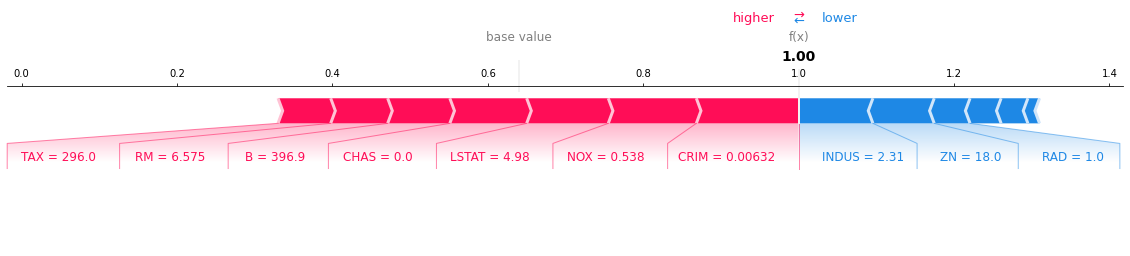

In [44]:
shap.plots.force(shap_values[0],  matplotlib=True)

An easier plot to read with the same insights is the *waterfall plot*. Instead of having all the variables in one row, we’ll have a line for each feature. The most significant features are listed in decreasing order, based on the absolute Shapley value of each feature on that observation.

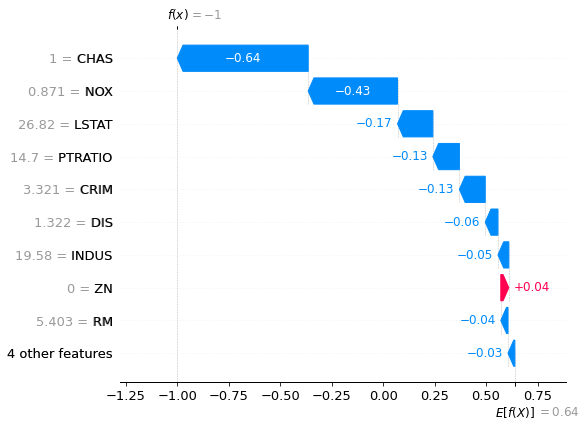

In [36]:
shap.plots.waterfall(shap_values[142])

Differently from the force plot, the waterfall provides a more elegant chart to visualize how the predicted output was obtained, given the contribution of each feature. It’s more evident how the positive (marked in red) and the negative (marked in blue) contribution of each variable moves the base value at the bottom to the model output at the top.§

## 5. Explain Single Feature
In the previous, you saw the contribution of the most relevant features in the prediction of an observation. But it would be probably better to check single features to understand better their impact on the outcome. This is possible using the **scatter plot**. It’s also called dependence plot.

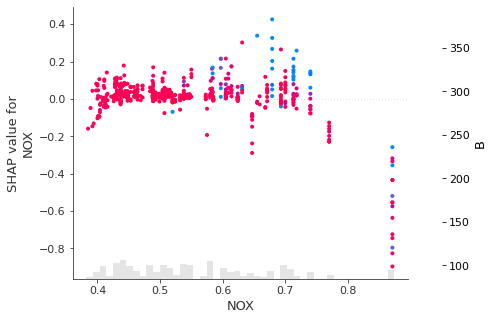

In [38]:
shap.plots.scatter(shap_values[:,'NOX'], color=shap_values)

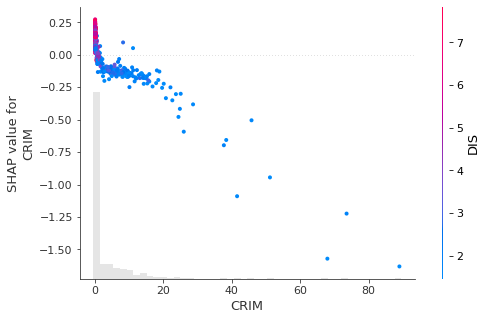

In [39]:
shap.plots.scatter(shap_values[:,'CRIM'], color=shap_values)


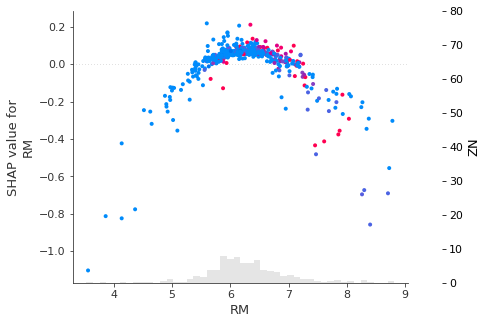

In [40]:
shap.plots.scatter(shap_values[:,'RM'], color=shap_values)

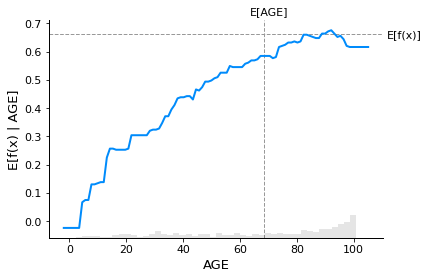

In [76]:
shap.plots.partial_dependence("AGE", iforest.predict, X, ice=False, model_expected_value=True, feature_expected_value=True)

## 6. Global interpretability
Finally, we can have an overview of the feature importance on the prediction, that looks at the entire dataset. Indeed, the graph is called summary plot:

In [77]:
shap.initjs()
shap.summary_plot(shap_values, X)

matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.


here are some relevant characteristics that need to be noticed:

* The features are ordered based on the sum of absolute Shapley values per feature across the data. Then, the top features contribute more to the model output since they have the largest absolute values.
* The different colours indicate the values of the features in the dataset. For example, if you look at the concentration of nitric oxide (NOX), it’s clear that high values of this feature imply that we have an anomalous item, while lower values bring to a normal item.

We can also display a bar plot, called global feature importance plot, in which the features are sorted by decreasing global importance. The global importance of each feature is calculated as the mean absolute value of that feature overall given rows of the dataset. We specify max_display to show all the features of the dataset.


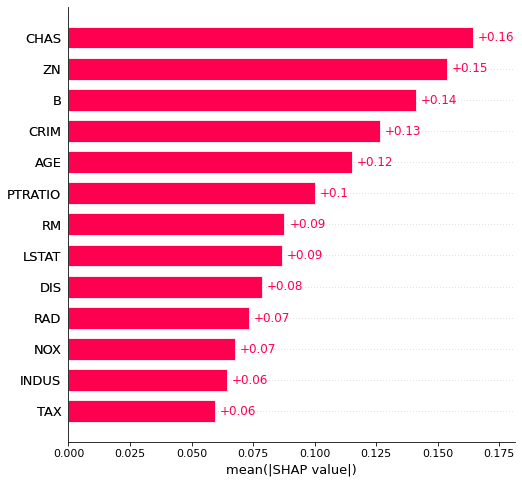

In [48]:
shap.plots.bar(shap_values,max_display=14)